# **Les statistiques sont menées sur la partie "Entraînement" du dataset**

**Dans ce notebook, le terme "bounding box" est traduit par "cadre englobant".**

# **Importation du dataset**

In [1]:
import tensorflow_datasets as tfds

data_name = 'voc/2007'
Train, info_train = tfds.load(data_name, split="train[:100%]", with_info=True)
num_classes = info_train.features['objects']['label'].num_classes
class_names = info_train.features['objects']['label'].names

print("Nombre d'images dans Train:", len(Train))
print("Nombre de classes:", num_classes)
print("Nombre de classes:", class_names)

X_train = list(Train.as_numpy_iterator())

2024-05-29 23:34:49.647638: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 23:34:49.862311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 23:34:49.862405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 23:34:49.864139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 23:34:50.016674: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 23:34:50.017760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Nombre d'images dans Train: 2501
Nombre de classes: 20
Nombre de classes: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# **IoU**

In [2]:
import torch

def IoU(boxes_preds: torch.Tensor, boxes_targets: torch.Tensor) -> torch.Tensor:
    """
    Calcule l'intersection sur union. Métrique utilisée pour mesurer la concordance de deux parallélogramme dans un repère.

    Parameters :
        boxes_preds: Prédictions des cadres englobants. (BATCH_SIZE, 4)
        boxes_targets: Cadres englobants réelles. (BATCH_SIZE, 4)

    Returns :
        Intersection sur l'union pour tous les cadres englobants.
    """

    preds_x1 = boxes_preds[..., 0:1]
    preds_y1 = boxes_preds[..., 1:2]
    preds_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3]
    preds_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4]
    targets_x1 = boxes_targets[..., 0:1]
    targets_y1 = boxes_targets[..., 1:2]
    targets_x2 = boxes_targets[..., 0:1] + boxes_targets[..., 2:3]
    targets_y2 = boxes_targets[..., 1:2] + boxes_targets[..., 3:4]

    x1 = torch.max(preds_x1, targets_x1)
    y1 = torch.max(preds_y1, targets_y1)
    x2 = torch.min(preds_x2, targets_x2)
    y2 = torch.min(preds_y2, targets_y2)

    # .clamp(0) est utilisé dans le cas où il n'y a pas d'intersection et permet de fixer le minimum 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    preds_area = abs((preds_x2 - preds_x1) * (preds_y2 - preds_y1))
    targets_area = abs((targets_x2 - targets_x1) * (targets_y2 - targets_y1))

    # 1e-6 est utilisé dans le cas quasi-impossible où les deux rectangles possèdent une aire égale à 0
    return intersection / (preds_area + targets_area - intersection + 1e-6)

# **Statistiques pour la méthode NMS**
**Dans le cas où la méthode supprime les cadres englobants redondants peu importe la classe.**

In [3]:
from tqdm import tqdm
IoUs = []
for example in tqdm(X_train):
    # Extraction de l'image et de ses données
    bboxes = example['objects']['bbox']

    new_bboxes = []
    for box in bboxes:
        y, x, y2, x2 = box
        w = (x2 - x)
        h = (y2 - y)
        new_bboxes.append([x, y, w, h])

    for index, box in enumerate(new_bboxes):
        for b in new_bboxes[index+1:]:
                iou = IoU(torch.tensor(box), torch.tensor(b)).item()
                IoUs.append(iou)

100%|██████████| 2501/2501 [00:02<00:00, 931.63it/s] 


In [4]:
print(f'Moyenne: {sum(IoUs)/len(IoUs)}')
print(f'Max: {max(IoUs)}')

Moyenne: 0.0343788791544121
Max: 0.9924716949462891


In [5]:
IoUs_Threshold = [0] * 10
for iou in tqdm(IoUs, total=len(IoUs)):
    res = int(iou * 10)
    IoUs_Threshold[res] += 1

100%|██████████| 20334/20334 [00:00<00:00, 1099554.92it/s]


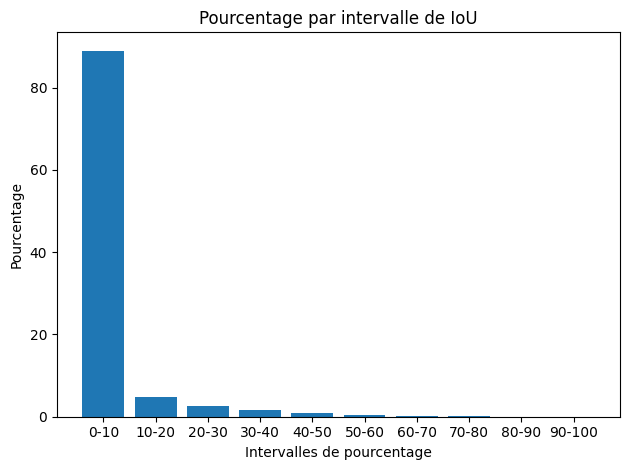

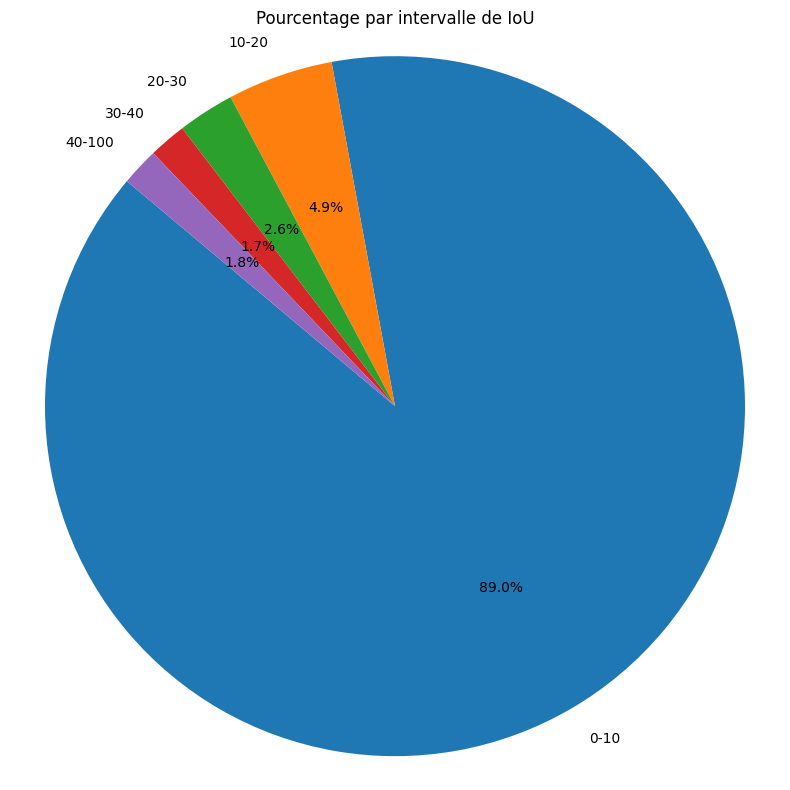

In [6]:
import matplotlib.pyplot as plt

percentages = [IoU_threshold / len(IoUs) * 100 for IoU_threshold in IoUs_Threshold if IoU_threshold]
labels = [f'{i * 10}-{(i+1) * 10}' for i in range(len(IoUs_Threshold))]

plt.bar(range(len(IoUs_Threshold)), percentages)
plt.xticks(range(len(IoUs_Threshold)), [f'{i * 10}-{(i+1) * 10}' for i in range(len(IoUs_Threshold))])
plt.xlabel('Intervalles de pourcentage')
plt.ylabel('Pourcentage')
plt.title('Pourcentage par intervalle de IoU')
plt.tight_layout()
plt.show()

i = 0
for index, p in enumerate(percentages):
    if p < 1:
        i = index
        break
percentages = [p for p in percentages[:i]] + [sum(percentages[i:])]
labels = [l for l in labels[:i]] + [labels[i].split('-')[0] + "-" + labels[-1].split('-')[1]]
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Pourcentage par intervalle de IoU')

plt.axis('equal')
plt.tight_layout()
plt.show()

# **Statistiques Classes**

In [7]:
import numpy as np
cmap = plt.get_cmap('tab20')

colors = [cmap(i / num_classes) for i in range(num_classes)]

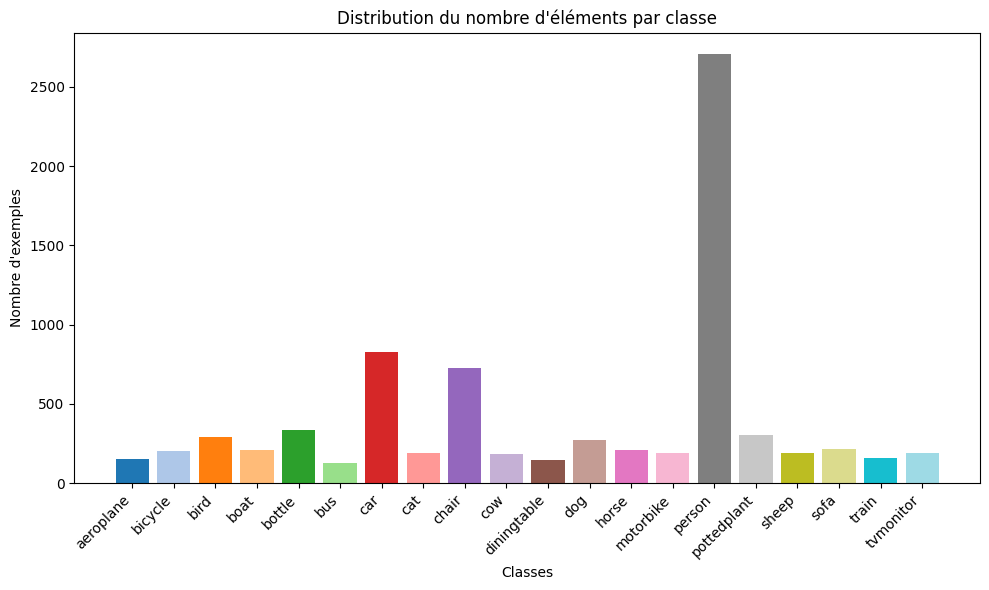

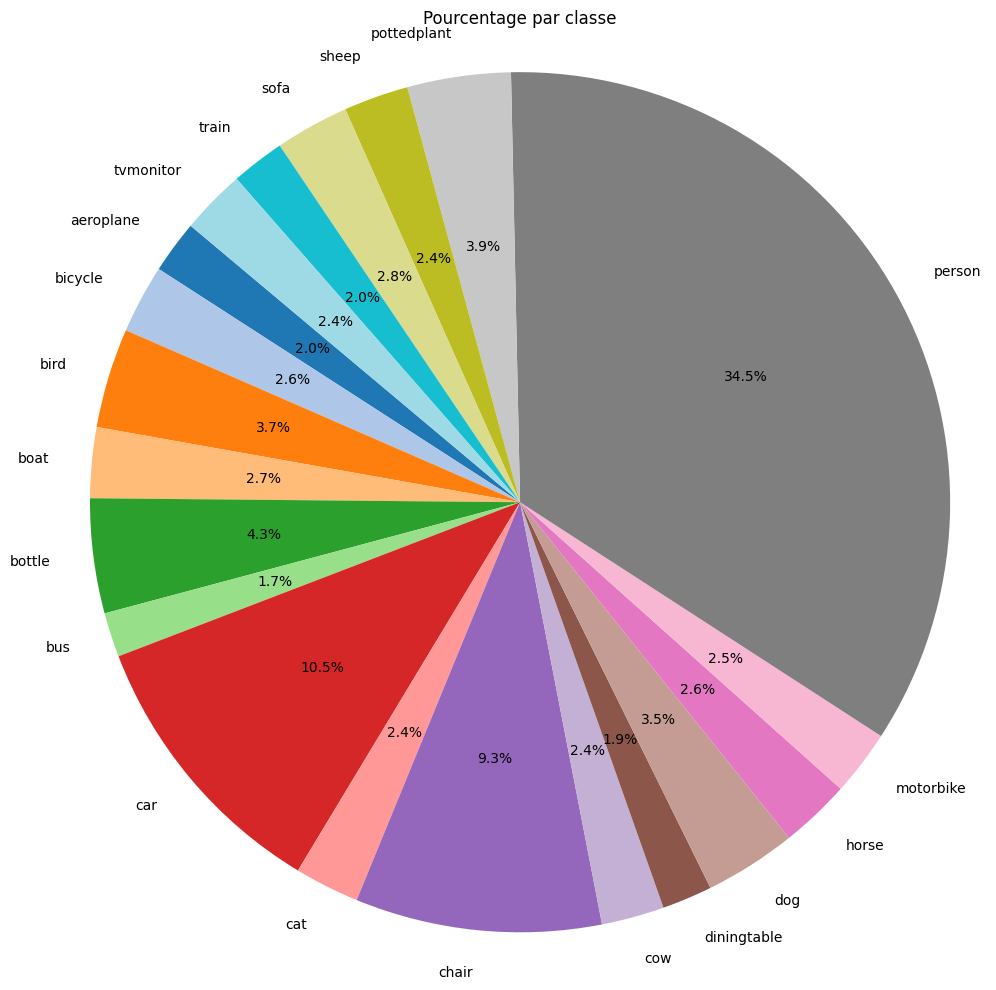

In [8]:
LABELS = [0] * num_classes

for example in X_train:
    labels = example['objects']['label']
    for label in labels:
        LABELS[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(range(len(class_names)), LABELS, color=colors)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution du nombre d\'éléments par classe')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.pie(LABELS, labels=class_names, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Pourcentage par classe')

plt.axis('equal')
plt.tight_layout()
plt.show()